In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [16]:
!nvidia-smi

Tue Nov 19 08:18:49 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [17]:
import torch

print("Number of GPU: ", torch.cuda.device_count())
print("GPU Name: ", torch.cuda.get_device_name())

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)


Number of GPU:  1
GPU Name:  Tesla P100-PCIE-16GB
Using device: cuda


In [18]:
import pandas as pd
import time
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# Load your scraped data from the provided URL
url = "https://raw.githubusercontent.com/amanullahshah32/Review-Scraping/refs/heads/main/Dataset/cleaned_dataset.csv"
df = pd.read_csv(url)

# Check the column names to find the appropriate columns
print(df.columns)

# Drop rows where 'review_description' or 'rating' are missing
df.dropna(subset=['review_description', 'rating'], inplace=True)

# Sample 20,000 rows randomly
df = df.sample(n=20000, random_state=42)

# Shuffle the sampled dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Create a sentiment column based on rating (assuming rating scale is 1-5)
# Mapping: 1-2 -> Negative, 3 -> Neutral, 4-5 -> Positive
df['sentiment'] = df['rating'].apply(lambda x: 0 if x <= 2 else (1 if x == 3 else 2))

# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(df['review_description'], df['sentiment'], test_size=0.2, random_state=42)

# Convert labels to list
train_labels = train_labels.tolist()
val_labels = val_labels.tolist()

# Optional: Display the first few rows of the shuffled dataframe
print(df.head())


Index(['source', 'review_id', 'user_name', 'review_title',
       'review_description', 'rating', 'thumbs_up', 'review_date',
       'developer_response', 'developer_response_date', 'appVersion',
       'language_code', 'country_code', 'app_name'],
      dtype='object')
        source                             review_id      user_name  \
0  Google Play  950646a1-c3af-491d-8293-f05be2150a48  A Google user   
1  Google Play  f28aa7ef-407e-41a5-bf99-a36a429bc091  A Google user   
2  Google Play  d829efbd-3415-4a11-b3a4-8a5eee3fd2d0  A Google user   
3  Google Play  0bfab82e-752a-4e53-9678-65d30b326b76  A Google user   
4  Google Play  840988cd-d51d-4630-b133-8b8ed40a3d7c  A Google user   

   review_title                                 review_description  rating  \
0           NaN  Seems to have just about every drug covered wi...       5   
1           NaN         Interesting, informative, and educational.       5   
2           NaN                         it's has very useful value  

In [19]:
from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Since train_texts is a pandas Series, we need to reshape it to a DataFrame
train_texts_df = pd.DataFrame(train_texts)

# Apply oversampling to balance the classes
train_texts_resampled, train_labels_resampled = ros.fit_resample(train_texts_df, train_labels)

# Convert the DataFrame of resampled texts back to a list
train_texts_resampled = train_texts_resampled.squeeze().tolist()


In [20]:
from transformers import AutoTokenizer

# Load the ClinicalBERT tokenizer (use Bio_ClinicalBERT for medical texts)
tokenizer = AutoTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT')

# Tokenize the text data
train_encodings = tokenizer(train_texts_resampled, truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(val_texts.tolist(), truncation=True, padding=True, max_length=128)


In [21]:
import torch
from torch.utils.data import Dataset

class ReviewDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# Create the PyTorch datasets
train_dataset = ReviewDataset(train_encodings, train_labels_resampled)
val_dataset = ReviewDataset(val_encodings, val_labels)


In [22]:
from transformers import AutoModelForSequenceClassification

# Load the pre-trained ClinicalBERT model for sequence classification (3 classes)
model = AutoModelForSequenceClassification.from_pretrained('emilyalsentzer/Bio_ClinicalBERT', num_labels=3)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
!pip install torch-optimizer --quiet


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [24]:
import torch_optimizer as optim


In [25]:
from torch.utils.data import DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
import torch_optimizer as optim  # Uncomment this if you install torch_optimizer

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

# Optimizer: trying AdamW with weight decay and a smaller learning rate
learning_rate = 3e-5  # Experiment with 1e-5 or 3e-5 for better optimization
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Alternatively, using AdamP for better weight decay handling
# optimizer = optim.AdamP(model.parameters(), lr=learning_rate, weight_decay=0.01)

# Update the total number of training steps for 3 epochs
epochs = 3  # Adjust the epoch count to 3
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [26]:
import numpy as np
import torch
from sklearn.utils.class_weight import compute_class_weight

# Define the device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# Convert the class labels to a NumPy array
classes = np.array([0, 1, 2])

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=classes, y=train_labels_resampled)

# Convert to a PyTorch tensor and move it to the appropriate device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Use the weights in the loss function
loss_fn = torch.nn.CrossEntropyLoss(weight=class_weights)


In [27]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)
device


device(type='cuda')

In [30]:
import time
import torch
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt

# Initialize lists to track metrics
train_accuracies = []
val_accuracies = []
epoch_durations = []


In [31]:
# Initialize lists to store accuracy and duration data
train_accuracies = []
val_accuracies = []
epoch_durations = []

# Loop for training and validation
for epoch in range(3):  # Training for 3 epochs
    start_time = time.time()  # Start time for the epoch

    # Training loop
    model.train()
    train_preds = []
    train_labels_epoch = []  # Track labels for each epoch
    for batch in train_loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        
        # Track predictions and true labels to calculate training accuracy
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        train_preds.extend(predictions.cpu().numpy())
        train_labels_epoch.extend(batch['labels'].cpu().numpy())  # Update epoch-specific labels
        
    # Calculate training accuracy for the epoch
    train_accuracy = accuracy_score(train_labels_epoch, train_preds)
    train_accuracies.append(train_accuracy)

    end_time = time.time()  # End time for the epoch
    epoch_duration = end_time - start_time
    epoch_durations.append(epoch_duration)

    # Validation loop
    model.eval()
    val_preds = []
    with torch.no_grad():
        for batch in val_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            predictions = torch.argmax(logits, dim=-1)
            val_preds.extend(predictions.cpu().numpy())

    # Calculate validation accuracy for the epoch
    val_accuracy = accuracy_score(val_labels, val_preds)
    val_accuracies.append(val_accuracy)
    # Print epoch results
    print(f"Epoch {epoch+1} | Train Acc: {train_accuracy:.4f} | Val Acc: {val_accuracy:.4f} | Time: {epoch_duration:.2f} seconds")


Epoch 1 | Train Acc: 0.8815 | Val Acc: 0.8910 | Time: 497.77 seconds
Epoch 2 | Train Acc: 0.9621 | Val Acc: 0.8940 | Time: 497.37 seconds
Epoch 3 | Train Acc: 0.9694 | Val Acc: 0.8925 | Time: 497.44 seconds


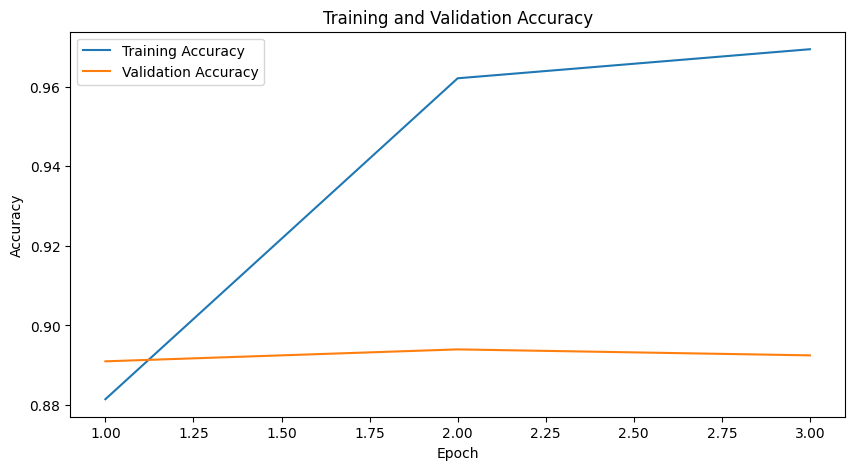

In [33]:
# Plot training and validation accuracy
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(range(1, 4), train_accuracies, label="Training Accuracy")
plt.plot(range(1, 4), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()
